In [1]:
import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import pandas as pd
import setigen
import os
import turbo_seti
%matplotlib inline

# for in-line (non-terminal) turboSETI
# as in Elan Lavie's notebook
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

numexpr.utils   INFO     Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [5]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc73_blp03/'
lfiles = ['blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [6]:
fb = bl.Waterfall(DATADIR+lfiles[0])

In [7]:
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1688.9648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

In [13]:
print(np.shape(fb.grab_data()[1]))

(16, 67108864)


In [9]:
from astropy import units as u
import setigen as stg

frame = stg.Frame(fchans=1024,
                  tchans=16,
                  df=2.7939677238464355*u.Hz,
                  dt=18.253611008*u.s,
                  fch1=1501.4648451469839*u.MHz,
                  ascending=False)

In [66]:
frame_path = stg.Frame.from_waterfall(DATADIR+lfiles[0])

In [ ]:
# [111, 1743, 362]

In [67]:
signal = frame_path.add_signal(stg.constant_path(f_start=1620.123445*u.MHz,
                                            drift_rate=-2.5*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=30)),
                          stg.sinc2_f_profile(width=40*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1548.435456*u.MHz,
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=20)),
                          stg.sinc2_f_profile(width=60*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1598.324118*u.MHz,
                                            drift_rate=1*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=100)),
                          stg.sinc2_f_profile(width=10*u.Hz),
                          stg.constant_bp_profile(level=1))

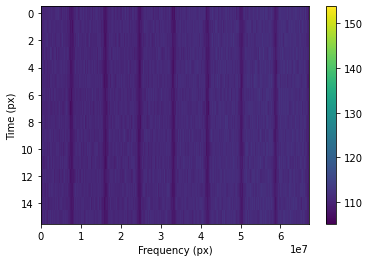

In [23]:
frame_path.plot("px")

In [68]:
wf = frame_path.get_waterfall()

In [27]:
frame_path.get_frequency(200)*1e-6

1501.4654039405286

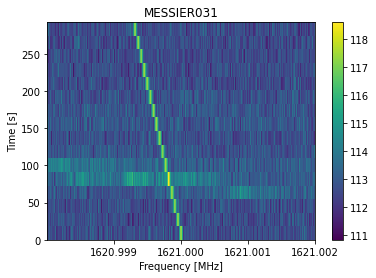

In [65]:
bw = 0.004
cf = frame_path.get_frequency(10000)*1e-6
cf = 1621
wf.plot_waterfall(f_start = cf-bw/2, f_stop = cf+bw/2, logged=True)

In [69]:
frame_path.save_fil(filename='/datax/scratch/benjb/m31_observation_with_setigen.fil')

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/benjb/m31_observation_with_setigen.fil in one go.
blimpy.waterfall INFO     Conversion time: 2.53sec


In [70]:
fb = bl.Waterfall('/datax/scratch/benjb/m31_observation_with_setigen.fil')

In [37]:
# Uncomment for copying files into scratch directory — hopefully shouldn't be necessary for en-masse runs?

for file in lfiles:
    console = f'cp {DATADIR}{file} /datax/scratch/benjb/'
    os.system(console)

In [9]:
# remove DC spikes in absence of turboSETI blank_DC option
# not needed for time-resolution spectra

data_loc = '/datax/scratch/benjb/C23_L_M31_injections'
files = glob.glob(data_loc + '/*.h5')

for file in files:
    fb = bl.Waterfall(file)
    fb.blank_dc(64)
    fb.write_to_hdf5(f'{data_loc}/bDC_{file[42:]}')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.91sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.92sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.88sec



--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1501.4648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

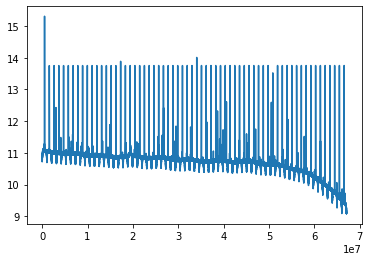

In [2]:
fb = bl.Waterfall('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb.info()
spec = np.average(np.squeeze(fb.data), axis=0)
plt.plot(np.log10(spec))
plt.show()

In [2]:
print('Beginning turboSETI search (FindDoppler version) ...')

data_loc = '/datax/scratch/benjb/C23_L_M31_injections'
files = glob.glob(data_loc + '/*.h5')

for file in files:
    doppler = FindDoppler(file,
                      max_drift = 4,
                      snr = 10,       
                      out_dir = data_loc,
                      n_coarse_chan = 64,
                      gpu_backend = True,
                      blank_dc = True
                     )
    doppler.search()

print('Done!')


Beginning turboSETI search (FindDoppler version) ...

turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 2.10.0
hdf5plugin version 2.1.2
HDF5 library version 1.10.5


data_handler    INFO     From user, n_coarse_chan=64
HDF5 header info: {'DIMENSION_LABELS': array([b'time', b'feed_id', b'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 1688.9648423530161, 'foff': -2.7939677238464355e-06, 'ibeam': 1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 67108864, 'nifs': 1, 'rawdatafile': 'guppi_58832_16209_MESSIER031_0057.0000.raw', 'source_name': 'MESSIER031', 'src_dej': <Angle 41.2677 deg>, 'src_raj': <Angle 0.71234667 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611008, 'tstart': 58832.18760416667, 'za_start': 0.0}

Starting ET search with parameters: datafile=/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=/datax/scratch/benjb/C23_L_M31_injections, coarse_ch

In [87]:
import pandas as pd
dat = glob.glob('/datax/scratch/benjb/C23_L_M31_injections/*.dat')[11]
print(dat)
df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
table_freqs = df['Uncorrected_Frequency'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_drifts = df['Drift_Rate'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_snrs = df['SNR'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]

/datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat


In [88]:
freqs = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc72.npy', allow_pickle=True)[0]
drifts = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc72.npy', allow_pickle=True)[1]
freqs_to_keep = []
for i, freq in enumerate(freqs):
    subtract_vec = table_freqs - freq
    if 0.0 in np.round(subtract_vec, 2):
        print(f'{freq}: {table_freqs[np.argmin(np.abs(subtract_vec))]}')
        print(f'   {drifts[i]}: {table_drifts[np.argmin(np.abs(subtract_vec))]}')
        freqs_to_keep.append(table_freqs[np.argmin(np.abs(subtract_vec))])
    else:
        print(f'Hit not found at {freq} MHz!')
        print(f'   Drift should be {drifts[i]} Hz/s. Plot later to check.')

# Write script to take just the "important" frequencies / drifts / SNRs 
# out of these .dats and add them to copies of Carmen's .dats

1858.5328806387947: 1858.532213
   -0.5199934197357092: -0.520417
1795.7806089159494: 1795.782369
   1.373146571296485: 1.387779
1821.0235813914187: 1821.026639
   2.3661299557145092: 2.275549
1690.4407574659094: 1690.441633
   0.6807269800271003: 0.683685
1739.339541379958: 1739.338485
   -0.8242879741486142: -0.81634
1745.6410927400218: 1745.637759
   -2.6025375550527405: -2.602085
1749.9156913266065: 1749.91291
   -2.1526797931612105: -2.122485
1736.3457869656454: 1736.348087
   1.7851362222040654: 1.714315
1841.548998534975: 1841.550748
   1.3601763830186417: 1.316349
1801.882689465336: 1801.881821
   -0.674124234263056: -0.663277
1841.5403170810541: 1841.541886
   1.218160845095725: 1.224511
1859.463456305124: 1859.466021
   2.0085391723284376: 2.102077
1773.055258912453: 1773.055858
   0.4672606216766555: 0.469396
1714.35068967933: 1714.353862
   2.4531763243813955: 2.398
1716.2302459577481: 1716.231347
   0.8604291718149364: 0.877566
1844.6202942488715: 1844.619053
   -0.9615638

In [89]:
print(len(freqs_to_keep))

25


In [90]:
dat_path = dat
new_dat_path = '/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_' + os.path.basename(dat_path)

lines = []
header = []

for i, line in enumerate(open(dat_path)):
    if i < 9:
        header.append(line)

for i in range(len(freqs_to_keep)):
    freq = freqs_to_keep[i]
    print(f'{i}: Keeping hit at frequency {freq} from {dat_path}')

    for line in open(dat_path):
        if str(freq) in line:
            lines.append(line)

with open(new_dat_path, 'w') as file:
    file.writelines(header)
    file.writelines(lines)
    file.close()

# Now write all of these into new .dat files, appended to Carmen's .dat files.
# They need not be meshed in frequency order.

0: Keeping hit at frequency 1858.532213 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
1: Keeping hit at frequency 1795.782369 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
2: Keeping hit at frequency 1821.026639 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
3: Keeping hit at frequency 1690.441633 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
4: Keeping hit at frequency 1739.338485 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
5: Keeping hit at frequency 1745.637759 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
6: Keeping hit at frequency 1749.91291 from /datax/scratch/benjb/C23_L_M31_injections/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.00

In [12]:
csv_file = '/home/cgchoza/galaxies/complete_cadences_catalog.csv'

df = pd.read_csv(csv_file)
dfl = df.iloc[np.where(df['Band'].values == 'L')[0]]

dat_list = []

del df
for line in dfl.iloc[np.where(dfl['Target'].values == 'MESSIER031')[0]]['.dat path'].values:
    if ('MESSIER031' in line) & (not 'blc71' in line) & (not 'blc76' in line):
        print(line)
        dat_list.append(line)

/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc74_blp04/blc7

In [19]:
old_dat_paths = np.sort(dat_list)
new_dat_paths = np.sort(glob.glob('/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_*.dat'))
print(len(old_dat_paths))
print(len(new_dat_paths))
for i in range(12):
    print(new_dat_paths[i])
    print('             ' + old_dat_paths[i])

12
12
/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
             /home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
             /home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
             /home/obs/turboseti/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_M31_injections/injected_retrieved_blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
         

In [20]:
for i in range(12):
    new_dat = new_dat_paths[i]
    old_dat = old_dat_paths[i]
    combined_dat_path = '/datax/scratch/benjb/C23_L_M31_injections/combined_' + os.path.basename(old_dat)

    new_lines = []
    old_lines = []
    header = []

    for j, line in enumerate(open(old_dat)):
        if j < 9:
            header.append(line)
        else:
            old_lines.append(line)

    for j, line in enumerate(open(new_dat)):
        if j < 9:
            continue
        else:
            new_lines.append(line)

    with open(combined_dat_path, 'w') as file:
        file.writelines(header)
        file.writelines(old_lines)
        file.writelines(new_lines)
        file.close()

In [8]:
arr = np.load('/datax/scratch/benjb/C23_L_M81_injections/injections_freq_DR_snr_widths_MESSIER081.npy', allow_pickle=True)
freqs = arr[0]
drifts = arr[1]
snrs = arr[2]
widths = arr[3]
print(arr.shape)

(4, 100)


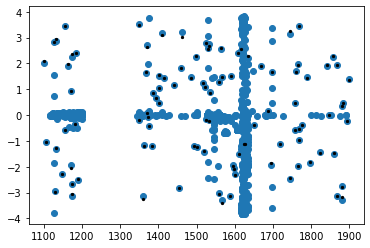

In [12]:
plt.scatter(table_freqs, table_drifts)
plt.scatter(freqs, drifts, s=5, c='k')
#plt.yscale('log')
plt.show()

In [17]:
counter = 0
for freq in freqs:
    diff_vec = table_freqs - freq
    if 0 in np.round(diff_vec, 3):
        counter += 1
print(counter)

idxs_vec = []
for freq in freqs:
    diff_vec = np.abs(table_freqs - freq)
    if 0 in np.round(diff_vec, 3):
        idx = np.argmin(diff_vec)
        idxs_vec.append(idx)

100


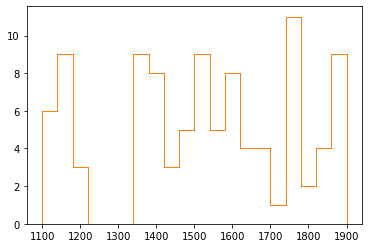

In [28]:
plt.hist(table_freqs[idxs_vec], bins=20, range=(1100, 1900), histtype='step')
plt.hist(freqs, bins=20, range=(1100, 1900), histtype='step')
plt.show()

In [29]:
np.save('/datax/scratch/benjb/C23_L_M81_injections/idxs_of_injections_in_dat.npy', idxs_vec)

In [13]:
import pandas as pd
dats = np.sort(glob.glob('/datax/scratch/benjb/C23_L_M31_injections/M31_dats_no_injections/blc7*.dat'))
freqs = []
drifts = []
snrs = []
for dat in dats:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs.append(table_freqs)
    drifts.append(table_drifts)
    snrs.append(table_snrs)
freqs = np.concatenate(freqs)
drifts = np.concatenate(drifts)
snrs = np.concatenate(snrs)

In [14]:
dats2 = ['/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat']

freqs2 = []
drifts2 = []
snrs2 = []
for dat in dats2:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs2.append(table_freqs)
    drifts2.append(table_drifts)
    snrs2.append(table_snrs)
freqs2 = np.concatenate(freqs2)
drifts2 = np.concatenate(drifts2)
snrs2 = np.concatenate(snrs2)

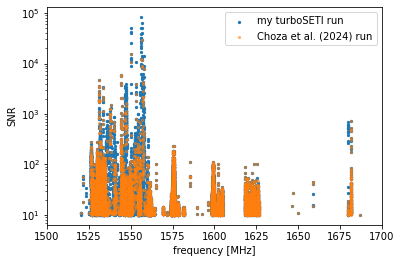

In [32]:
plt.scatter(freqs, snrs, s=5, alpha=1, label='my turboSETI run')
plt.scatter(freqs2, snrs2, s=5, alpha=0.5, label='Choza et al. (2024) run')
plt.yscale('log')
plt.xlabel('frequency [MHz]')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.xlim(1500,1700)
plt.show()

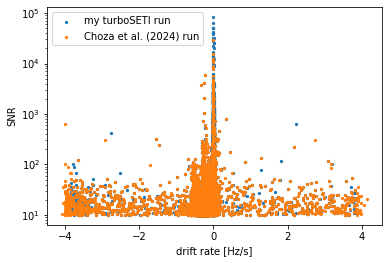

In [30]:
plt.scatter(drifts, snrs, s=5, alpha=1, label='my turboSETI run')
plt.scatter(drifts2, snrs2, s=5, alpha=1, label='Choza et al. (2024) run')
plt.yscale('log')
plt.xlabel('drift rate [Hz/s]')
plt.ylabel('SNR')
plt.legend(loc='upper left')
plt.show()

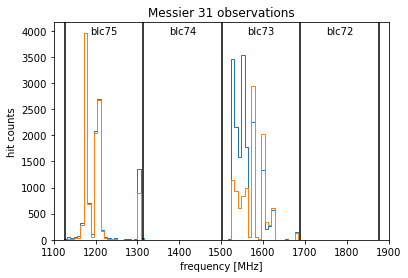

In [9]:
plt.hist(freqs, bins=100, histtype='step', range=(1100, 1900))
plt.hist(freqs2, bins=100, histtype='step', range=(1100, 1900))
plt.axvline(1126.4648451469839, color='k')
plt.axvline(1313.9648451469839, color='k')
plt.axvline(1501.4648451469839, color='k')
plt.axvline(1688.9648451469839, color='k')
plt.axvline(1876.4648423530161, color='k')
plt.text(1313.9648451469839-187.5/2, 4000, 'blc75', horizontalalignment='center', verticalalignment='center')
plt.text(1501.4648451469839-187.5/2, 4000, 'blc74', horizontalalignment='center', verticalalignment='center')
plt.text(1688.9648451469839-187.5/2, 4000, 'blc73', horizontalalignment='center', verticalalignment='center')
plt.text(1876.4648423530161-187.5/2, 4000, 'blc72', horizontalalignment='center', verticalalignment='center')
plt.ylabel('hit counts')
plt.xlabel('frequency [MHz]')
plt.title('Messier 31 observations')
plt.xlim(1100, 1900)
#plt.yscale('log')
plt.show()

In [33]:
import pandas as pd
dats = np.sort(glob.glob('/datax/scratch/benjb/C23_L_M31_injections/M31_dats_no_injections/blc0*.dat'))
freqs = []
drifts = []
snrs = []
for dat in dats:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs.append(table_freqs)
    drifts.append(table_drifts)
    snrs.append(table_snrs)
freqs = np.concatenate(freqs)
drifts = np.concatenate(drifts)
snrs = np.concatenate(snrs)

In [34]:
dats2 = ['/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_32541_MESSIER033_0010.rawspec.0000/blc03_guppi_59884_32541_MESSIER033_0010.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_32854_HIP7229_0011.rawspec.0000/blc03_guppi_59884_32854_HIP7229_0011.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33167_MESSIER033_0012.rawspec.0000/blc03_guppi_59884_33167_MESSIER033_0012.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33484_HIP7612_0013.rawspec.0000/blc03_guppi_59884_33484_HIP7612_0013.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33801_MESSIER033_0014.rawspec.0000/blc03_guppi_59884_33801_MESSIER033_0014.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_34123_HIP7960_0015.rawspec.0000/blc03_guppi_59884_34123_HIP7960_0015.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_32541_MESSIER033_0010.rawspec.0000/blc05_guppi_59884_32541_MESSIER033_0010.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_32854_HIP7229_0011.rawspec.0000/blc05_guppi_59884_32854_HIP7229_0011.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33167_MESSIER033_0012.rawspec.0000/blc05_guppi_59884_33167_MESSIER033_0012.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33484_HIP7612_0013.rawspec.0000/blc05_guppi_59884_33484_HIP7612_0013.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33801_MESSIER033_0014.rawspec.0000/blc05_guppi_59884_33801_MESSIER033_0014.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_34123_HIP7960_0015.rawspec.0000/blc05_guppi_59884_34123_HIP7960_0015.rawspec.0000.dat']

freqs2 = []
drifts2 = []
snrs2 = []
for dat in dats2:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs2.append(table_freqs)
    drifts2.append(table_drifts)
    snrs2.append(table_snrs)
freqs2 = np.concatenate(freqs2)
drifts2 = np.concatenate(drifts2)
snrs2 = np.concatenate(snrs2)

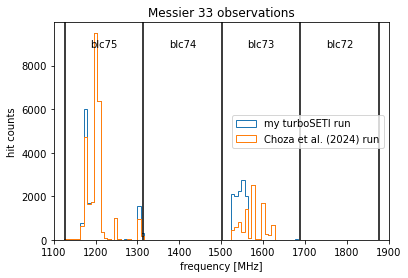

In [37]:
plt.hist(freqs, bins=100, histtype='step', range=(1100, 1900), label='my turboSETI run')
plt.hist(freqs2, bins=100, histtype='step', range=(1100, 1900), label='Choza et al. (2024) run')
plt.axvline(1126.4648451469839, color='k')
plt.axvline(1313.9648451469839, color='k')
plt.axvline(1501.4648451469839, color='k')
plt.axvline(1688.9648451469839, color='k')
plt.axvline(1876.4648423530161, color='k')
plt.text(1313.9648451469839-187.5/2, 9000, 'blc75', horizontalalignment='center', verticalalignment='center')
plt.text(1501.4648451469839-187.5/2, 9000, 'blc74', horizontalalignment='center', verticalalignment='center')
plt.text(1688.9648451469839-187.5/2, 9000, 'blc73', horizontalalignment='center', verticalalignment='center')
plt.text(1876.4648423530161-187.5/2, 9000, 'blc72', horizontalalignment='center', verticalalignment='center')
plt.ylabel('hit counts')
plt.xlabel('frequency [MHz]')
plt.title('Messier 33 observations')
plt.xlim(1100, 1900)
plt.legend(loc='center right')
#plt.yscale('log')
plt.show()

In [5]:
print('Beginning turboSETI search (command line version) ...')

for i in range(len(lfiles)):
    # Execute turboSETI in the terminal
    console = 'turboSETI ' + DATADIR + lfiles[i] + ' -M 4 -s 10 -o' + '/datax/scratch/benjb/'
    os.system(console)

print('Done!')

Beginning turboSETI search ...
Done!


In [5]:
print('Beginning plotSETI algorithm ...')

console = "plotSETI -f 3 -o " + DATADIR + " " + DATADIR
print(console)
os.system(console)

print('Done!')

Beginning plotSETI algorithm ...
plotSETI -f 3 -o /datax/scratch/benjb/m31_data/ /datax/scratch/benjb/m31_data/
Done!


In [ ]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc75_blp05/'
lfiles = ['blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [66]:
# Create a simple .lst file of the .h5 files in the data directory
h5_list= ['/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
          '/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
          '/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']
#h5_list = [
#    '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
#'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
#'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
#'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
#'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
#'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5'
#]
#h5_list = [DATADIR + file for file in lfiles]

data_loc = '/datax/scratch/benjb/C23_L_M31_injections'

# This writes the .h5 files into a .lst, as required by the find_event_pipeline:
h5_list_path = os.path.join(data_loc,'blc75_M31_h5_files.lst')
with open(h5_list_path, 'w') as f:
    for h5_path in h5_list:
        f.write(h5_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(h5_list_path, 'r') as f:
    print(f.read())

/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5



In [67]:
# Create a simple .lst file of the .dat files in the data directory
dat_list = [
'/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat'
]
# dat_list = [
#     '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
# '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
# '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
# '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
# '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
# '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat'
# ]
#dat_list = [data_loc + file[:-2] + 'dat' for file in lfiles]
    
# This writes the .dat files into a .lst, as required by the find_event_pipeline:
dat_list_path = os.path.join(data_loc, 'blc75_M31_dat_files.lst')
with open(dat_list_path, 'w') as f:
    for dat_path in dat_list:
        f.write(dat_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(dat_list_path, 'r') as f:
    print(f.read())

/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat
/datax/scratch/benjb/C23_L_M31_injections/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat



In [68]:
csvf_path = os.path.join(data_loc, 'blc75_M31_C23_plus_injections_found_event_table_3.csv')
find_event_pipeline(dat_list_path, 
                    h5_list_path,
                    SNR_cut=10,
                    check_zero_drift=True,
                    filter_threshold = 3, 
                    number_in_cadence = 6, 
                    csv_name=csvf_path, 
                    saving=True)


===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
find_event_pipeline INFO     file=blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat, tstart=58832.18760416667, source_name=MESSIER031, fch1=1313.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat, tstart=58832.19131944444, source_name=HIP2792, fch1=1313.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat, tstart=58832.19503472222, source_name=MESSIER031, fch1=1313.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat, tstart=58832.1987037037, source_name=HIP3077, fch1=1313.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc75_guppi_58832_17485_MES

TopHitNum  DriftRate          SNR         Freq  ChanIndx    FreqStart  \
1510       1511  -0.193881  1429.708740  1197.184275    902929  1197.186466   
3235        753  -0.204085  1574.704346  1197.184147    902975  1197.186337   
5644       1359  -0.204085  1477.941162  1197.184018    903021  1197.186209   
1531       1532   1.418392   123.505241  1196.574696     72530  1196.576886   
3237        755   1.500026   121.995239  1196.575632     72195  1196.577822   
...         ...        ...          ...          ...       ...          ...   
4284       1802   2.010238    68.981514  1129.731443    927990  1129.733634   
6554       2269   1.928604    70.201492  1129.732740    927526  1129.734930   
2482       2483  -1.132672    71.479713  1127.031534    845749  1127.033725   
4285       1803  -1.102060    73.504990  1127.030797    846013  1127.032987   
6556       2271  -1.153081    73.031448  1127.030082    846269  1127.032272   

          FreqEnd  CoarseChanNum  FullNumHitsInRange  \
1510  1197.182088             39               79594   
3235  1197.181959             39               56585   
5644  1197.181831             39               54354   
1531  1196.572508             40               27349   
3237  1196.573444             40               29350   
...           ...            ...                 ...   
4284  1129.729256             62               25017   
6554  1129.730552             62               31176   
2482  1127.029347             63                2449   
4285  1127.028609             63                2683   
6556  1127.027894             63                2829   

                                                 FileID  ...           DEC  \
1510  blc75_guppi_58832_16209_MESSIER031_0057.gpuspe...  ...  41d16m03.72s   
3235  blc75_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...  41d15m33.12s   
5644  blc75_guppi_58832_17485_MESSIER031_0061.gpuspe...  ...  41d15m39.24s   
1531  blc75_guppi_58832_16209_MESSIER031_0057.gpuspe...  ...  41d16m03.72s   
3237  blc75_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...  41d15m33.12s   
...                                                 ...  ...           ...   
4284  blc75_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...  41d15m33.12s   
6554  blc75_guppi_58832_17485_MESSIER031_0061.gpuspe...  ...  41d15m39.24s   
2482  blc75_guppi_58832_16209_MESSIER031_0057.gpuspe...  ...  41d16m03.72s   
4285  blc75_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...  41d15m33.12s   
6556  blc75_guppi_58832_17485_MESSIER031_0061.gpuspe...  ...  41d15m39.24s   

         DELTAT     DELTAF max_drift_rate  obs_length           Hit_ID  \
1510  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1510   
3235  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1510   
5644  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1510   
1531  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1531   
3237  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1531   
...         ...        ...            ...         ...              ...   
4284  18.253611  -2.793968       4.000000  292.057776  MESSIER031_2480   
6554  18.253611  -2.793968       4.000000  292.057776  MESSIER031_2480   
2482  18.253611  -2.793968       4.000000  292.057776  MESSIER031_2482   
4285  18.253611  -2.793968       4.000000  292.057776  MESSIER031_2482   
6556  18.253611  -2.793968       4.000000  292.057776  MESSIER031_2482   

          status in_n_ons RFI_in_range delta_t  
1510  on_table_1        2            0     0.0  
3235  on_table_2                     0   642.0  
5644  on_table_3                     0  1276.0  
1531  on_table_1        2            0     0.0  
3237  on_table_2                     0   642.0  
...          ...      ...          ...     ...  
4284  on_table_2                     0   642.0  
6554  on_table_3                     0  1276.0  
2482  on_table_1        2            0     0.0  
4285  on_table_2                     0   642.0  
6556  on_table_3   

In [30]:
df = pd.read_csv(tcsvf_path)
found_freqs = df['Freq'].values
found_drifts = df['DriftRate'].values
found_snrs = df['SNR'].values

In [31]:
arr = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc73.npy')
freqs = arr[0]
drifts = arr[1]
snrs = arr[2]

In [32]:
print(np.sort(freqs))

[1507.45544409 1512.2988503  1517.08311758 1517.71150312 1518.2319486
 1519.94142936 1528.07389281 1548.08959106 1548.3657349  1565.03447602
 1573.6885546  1576.08321989 1577.05037056 1581.16106631 1598.98780122
 1617.00186145 1618.8124975  1634.26493193 1656.21772703 1657.36351805
 1658.46533314 1676.49676724 1680.4525218  1680.72202531 1682.5691726 ]


In [33]:
print(np.sort(found_freqs))

[1507.455425 1512.298846 1517.083125 1517.711502 1518.231962 1519.941426
 1526.953193 1526.973804 1527.0109   1528.073892 1528.342303 1528.751058
 1529.578972 1529.823383 1529.839566 1529.856053 1530.232336 1530.23829
 1530.279509 1530.316909 1530.372328 1530.426827 1530.458429 1530.492778
 1530.505449 1530.631862 1531.206942 1531.240542 1532.000107 1532.810942
 1533.226151 1533.256683 1533.274011 1533.362172 1533.371484 1533.74252
 1533.858847 1533.902358 1534.116957 1534.160557 1536.062729 1536.089629
 1537.848058 1540.412744 1540.462728 1540.57395  1540.589639 1540.681133
 1540.735495 1546.024043 1546.312609 1546.327009 1546.334209 1547.555908
 1548.089578 1548.365742 1565.034481 1573.688562 1577.050359 1581.16107
 1617.001876 1618.812493 1634.264931 1656.217744 1657.363539 1658.465315
 1676.496781 1680.45252  1680.722056 1682.569168]


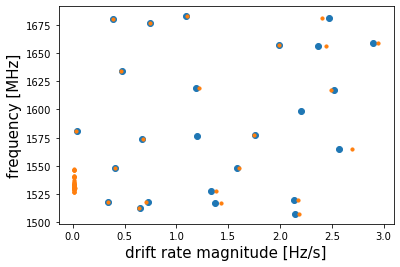

In [34]:
plt.scatter(np.abs(drifts), freqs)
plt.scatter(np.abs(found_drifts), found_freqs, s=10)
plt.xlabel('drift rate magnitude [Hz/s]', size=15)
plt.ylabel('frequency [MHz]', size=15)
plt.show()

In [69]:
# and finally we plot
import pandas as pd
event_df = pd.read_csv(csvf_path)
event_df = event_df.iloc[
    np.where(((event_df['Freq'].values > 1100) & (event_df['Freq'].values < 1200)) |
             ((event_df['Freq'].values > 1340) & (event_df['Freq'].values < 1900)))[0]]
event_df.dropna(subset=['in_n_ons'], inplace=True)
event_df.to_csv(f'/datax/scratch/benjb/C23_L_M31_injections/blc75_M31_C23_plus_injections_found_event_table_3_trimmed.csv')
tcsvf_path = '/datax/scratch/benjb/C23_L_M31_injections/blc75_M31_C23_plus_injections_found_event_table_3_trimmed.csv'


In [46]:
c23_events_path = '/home/cgchoza/BL-TESSsearch/analysis/event_data.csv'
dfc = pd.read_csv(c23_events_path)
dfc0 = dfc.iloc[np.where(dfc['Source'].values=='MESSIER031')[0]]
dfc0

Unnamed: 0  Unnamed: 0.1  TopHitNum  DriftRate         SNR         Freq  \
1100           0          1460       1461  -0.009566   23.427170  1547.555908   
1101           1          2868        966  -0.010204   18.226017  1547.555903   
1102           2          4846       1623  -0.009566   26.088745  1547.555897   
1103           3          1805       1806  -0.009566  156.771561  1529.839566   
1104           4          3157       1255  -0.010204   81.426376  1529.839560   
1105           5          5115       1892  -0.009566   62.900444  1529.839554   

      ChanIndx    FreqStart      FreqEnd  CoarseChanNum  ...    DELTAF  \
1100    280581  1547.557543  1547.554279             48  ... -2.793968   
1101    280583  1547.555903  1547.555903             48  ... -2.793968   
1102    280585  1547.557531  1547.554268             48  ... -2.793968   
1103    330051  1529.841200  1529.837937             54  ... -2.793968   
1104    330053  1529.839560  1529.839560             54  ... -2.793968   
1105    330055  1529.841189  1529.837925             54  ... -2.793968   

     max_drift_rate  obs_length           Hit_ID      status in_n_ons  \
1100            4.0  292.057776  MESSIER031_1460  on_table_1      2.0   
1101            4.0  292.057776  MESSIER031_1460  on_table_2      NaN   
1102            4.0  292.057776  MESSIER031_1460  on_table_3      NaN   
1103            4.0  292.057776  MESSIER031_1805  on_table_1      2.0   
1104            4.0  292.057776  MESSIER031_1805  on_table_2      NaN   
1105            4.0  292.057776  MESSIER031_1805  on_table_3      NaN   

      RFI_in_range  delta_t  Band  \
1100             0      0.0     L   
1101             0    642.0     L   
1102             0   1276.0     L   
1103             0      0.0     L   
1104             0    642.0     L   
1105             0   1276.0     L   

                                               FilePath  
1100  /home/obs/events/47067/1688/found_event_table.csv  
1101  /home/obs/events/47067/1688/found_event_table.csv  
1102  /home/obs/events/47067/1688/found_event_table.csv  
1103  /home/obs/events/47067/1688/found_event_table.csv  
1104  /home/obs/events/47067/1688/found_event_table.csv  
1105  /home/obs/events/47067/1688/found_event_table.csv  

[6 rows x 27 columns]

plot_event_pipeline: Opened file /datax/scratch/benjb/C23_L_M31_injections/blc75_M31_C23_plus_injections_found_event_table_3_trimmed.csv
plot_event_pipeline: file = blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5, tstart = 58832.18760416667, source_name = MESSIER031
plot_event_pipeline: file = blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5, tstart = 58832.19131944444, source_name = HIP2792
plot_event_pipeline: file = blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5, tstart = 58832.19503472222, source_name = MESSIER031
plot_event_pipeline: file = blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5, tstart = 58832.1987037037, source_name = HIP3077
plot_event_pipeline: file = blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5, tstart = 58832.202372685184, source_name = MESSIER031
plot_event_pipeline: file = blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5, tstart = 58832.206030092595, source_name = HIP3223
Plotting some events for:  MESSIER031
There are 24 t

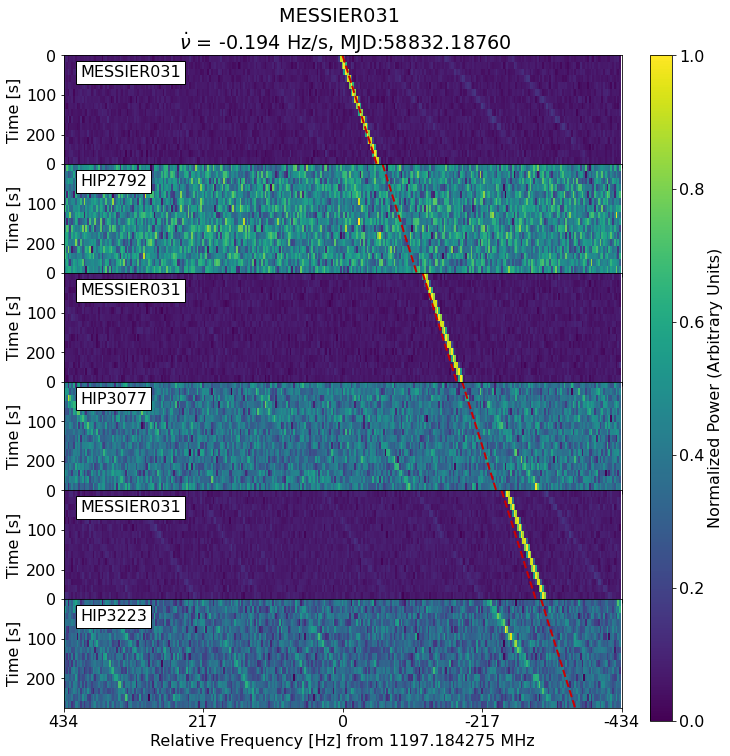

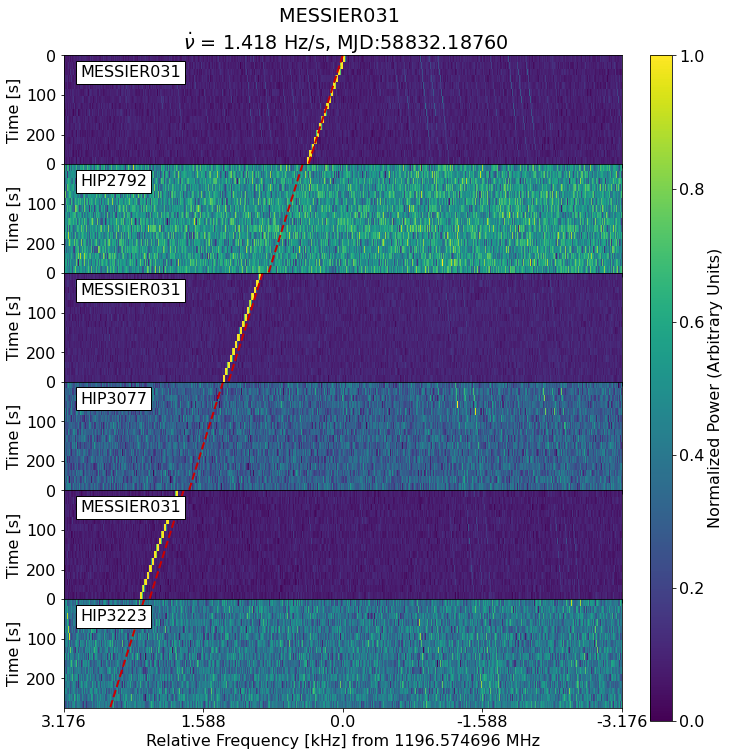

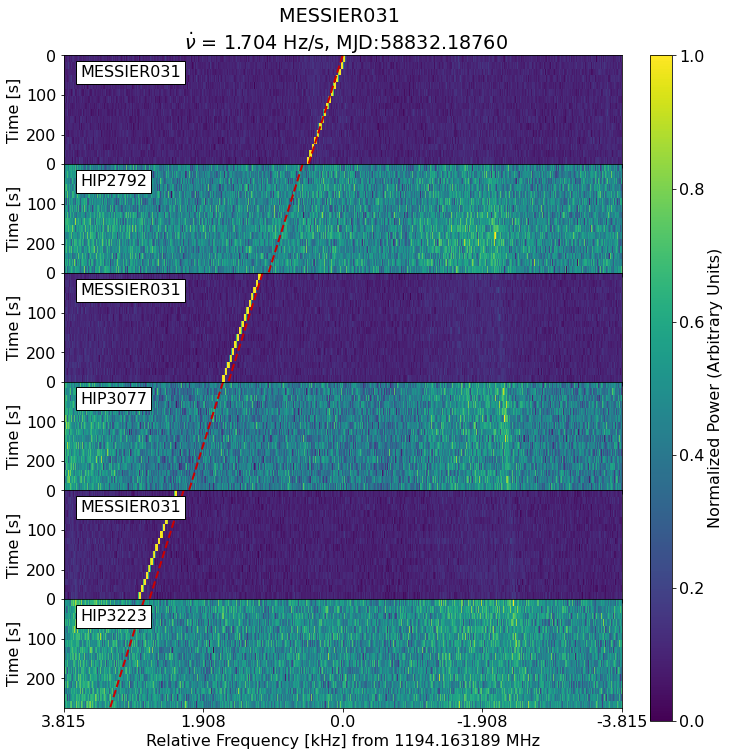

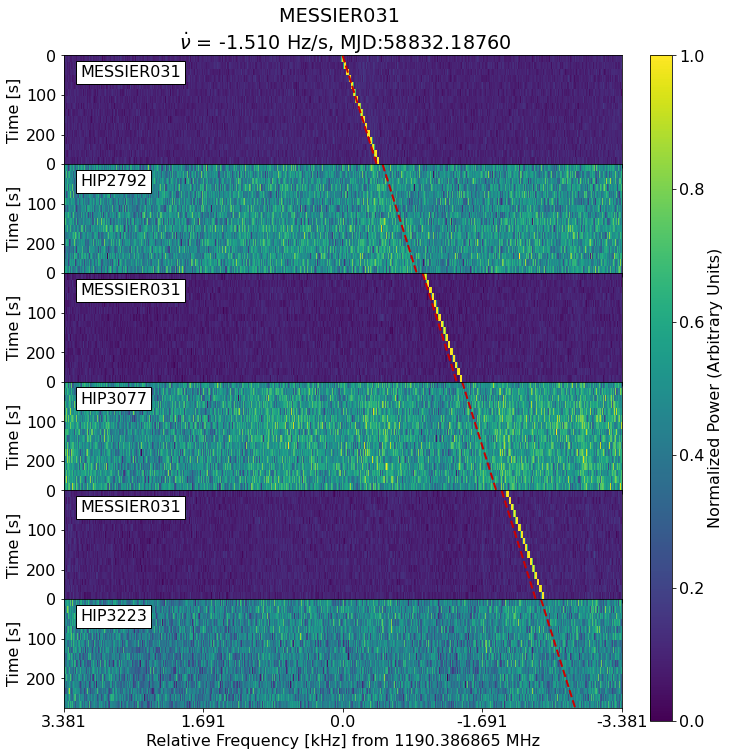

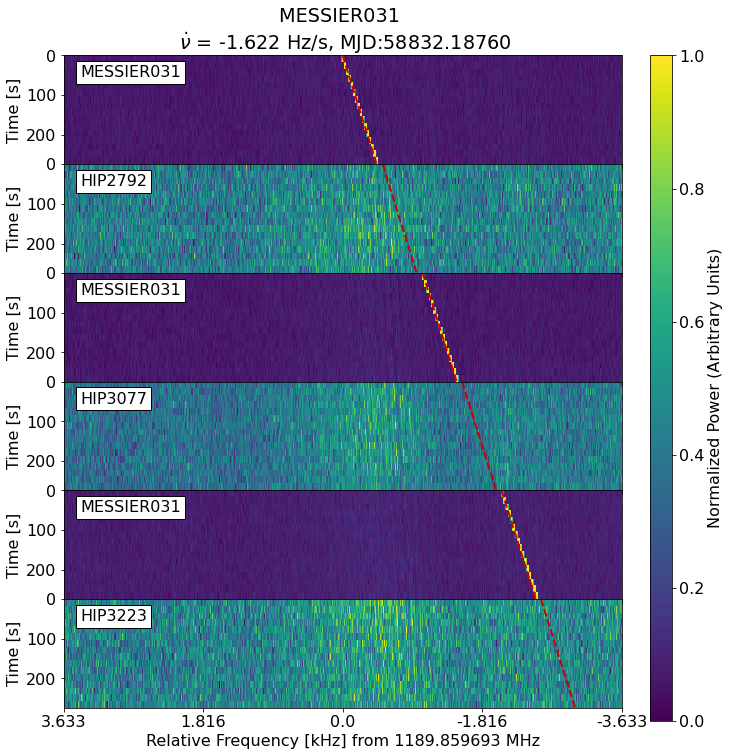

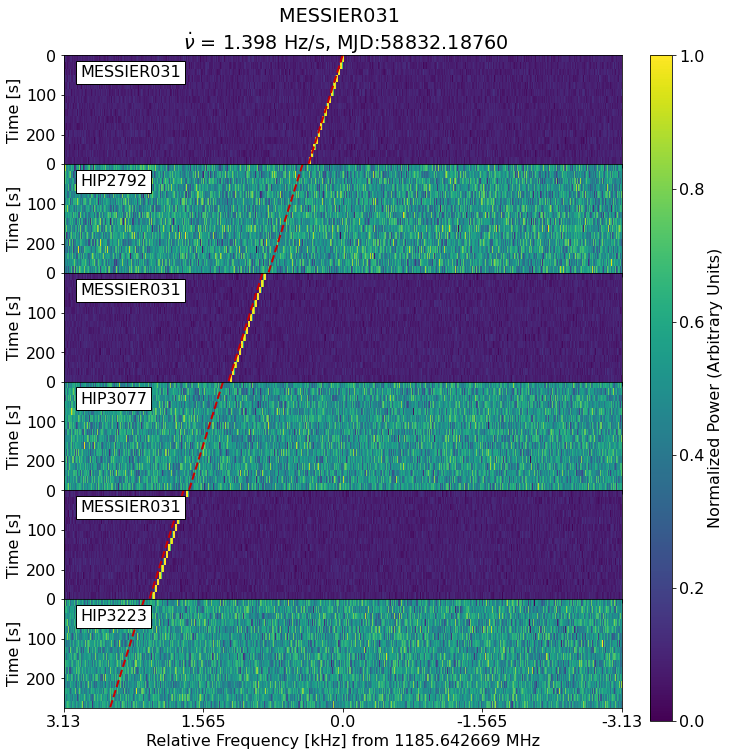

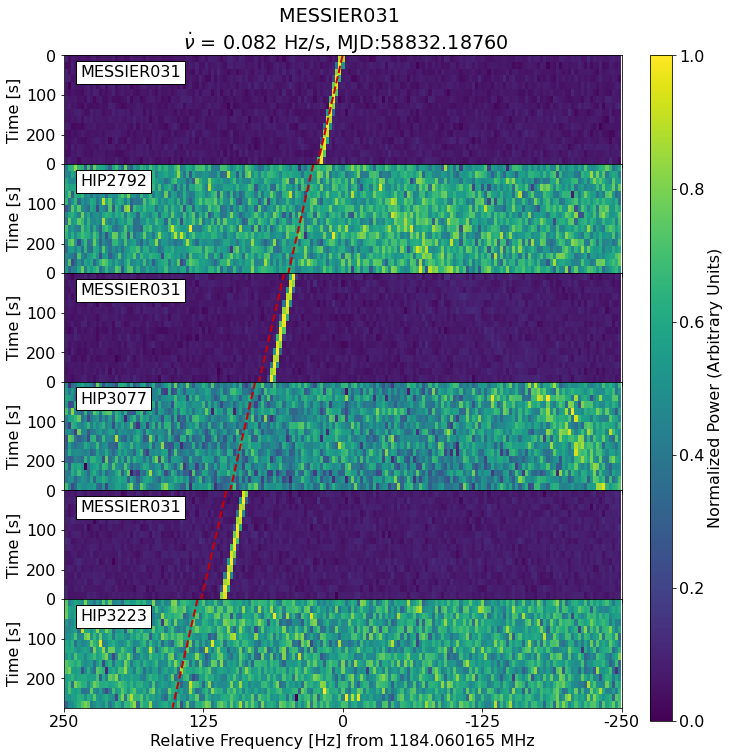

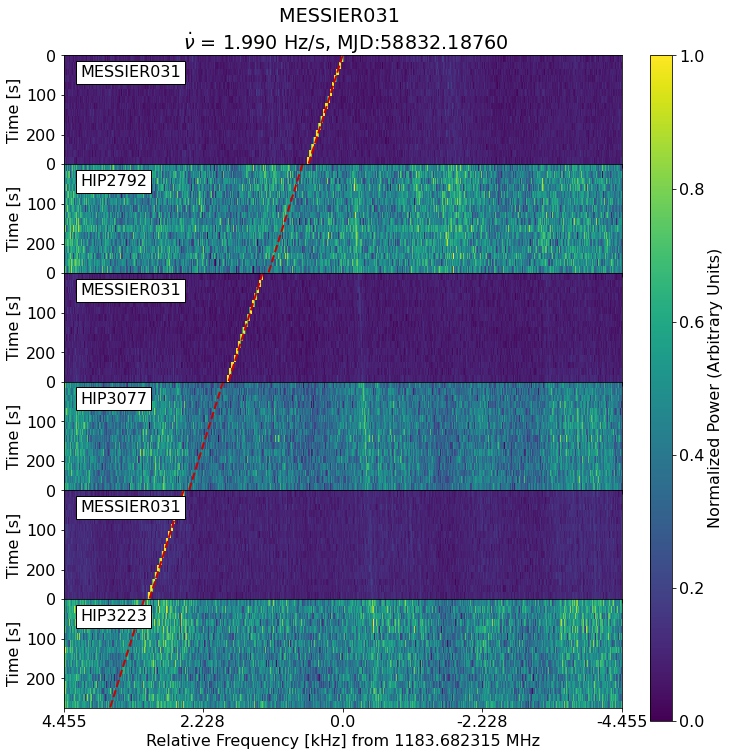

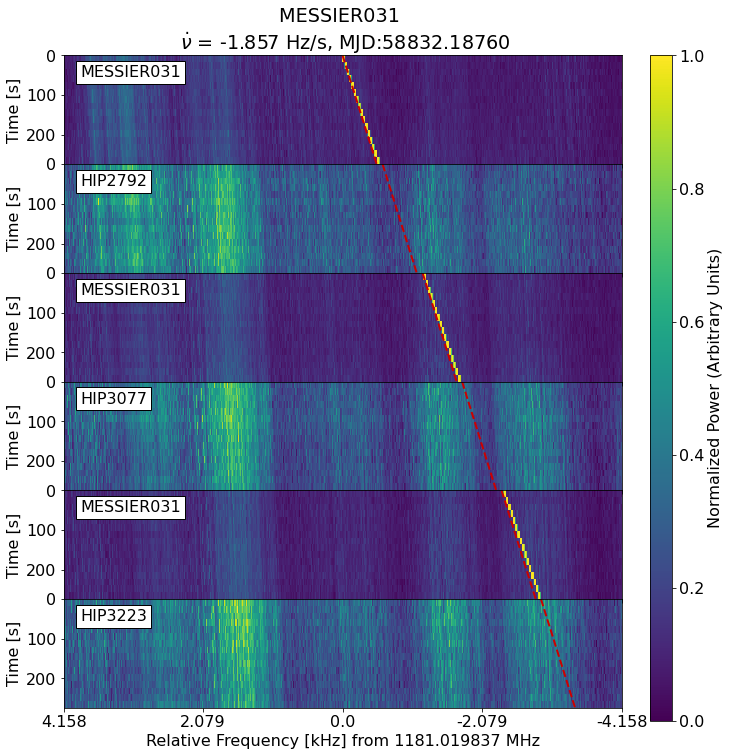

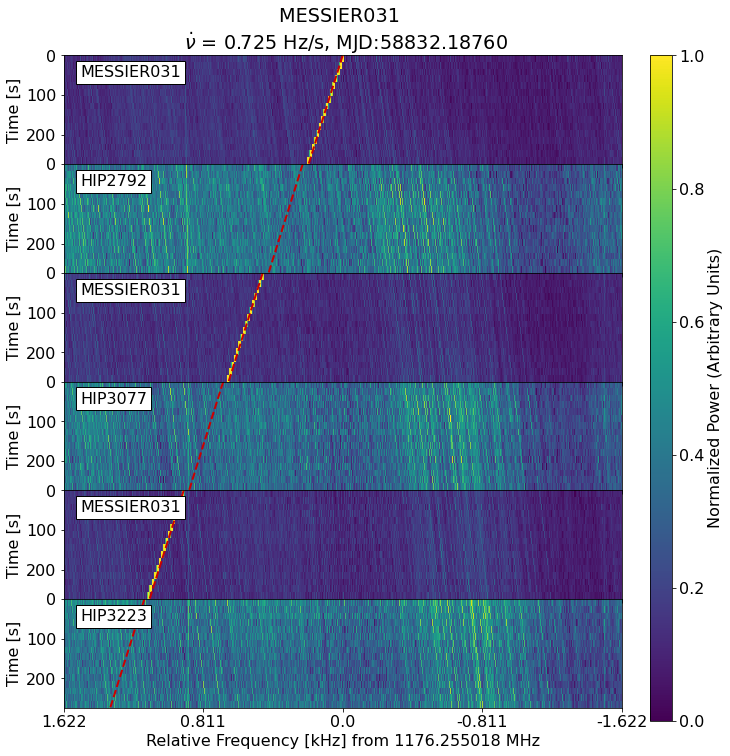

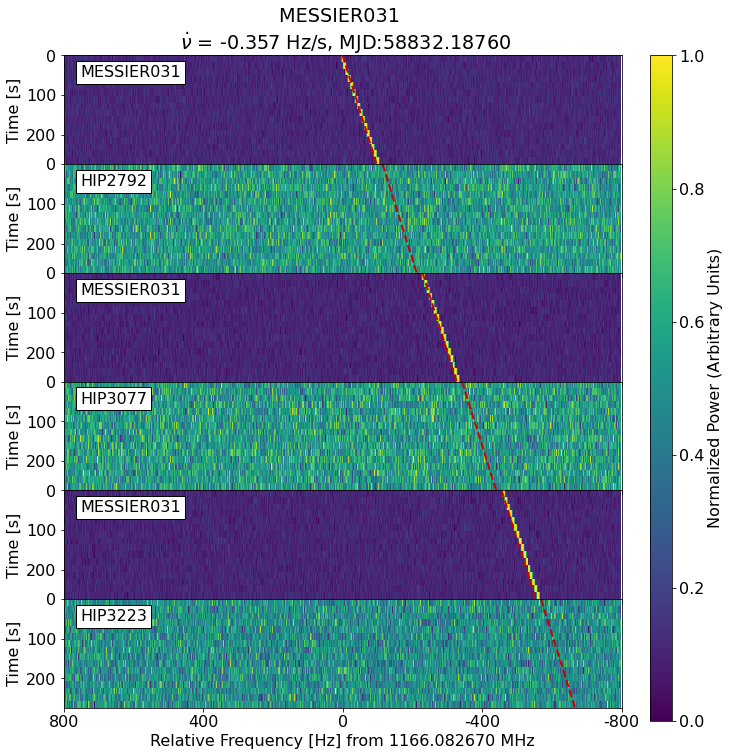

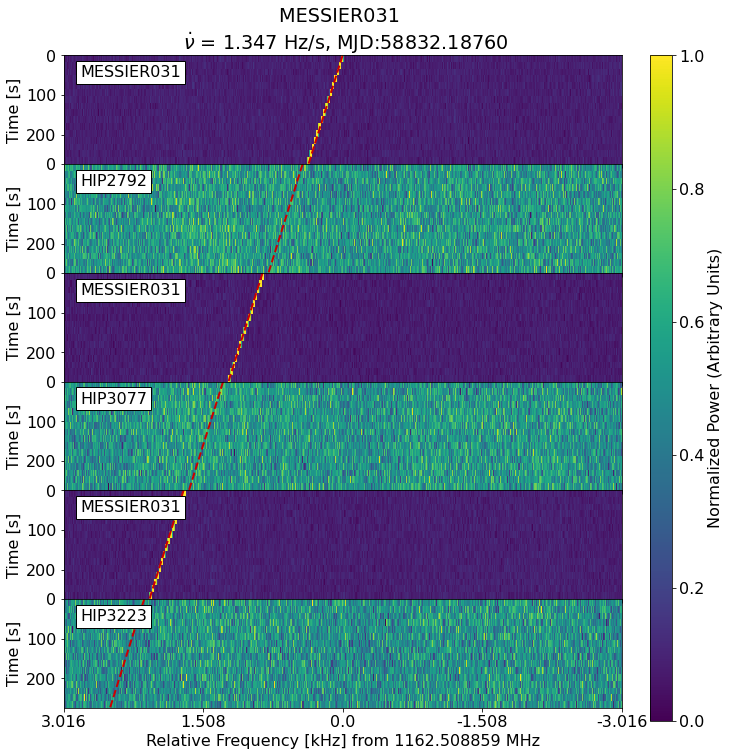

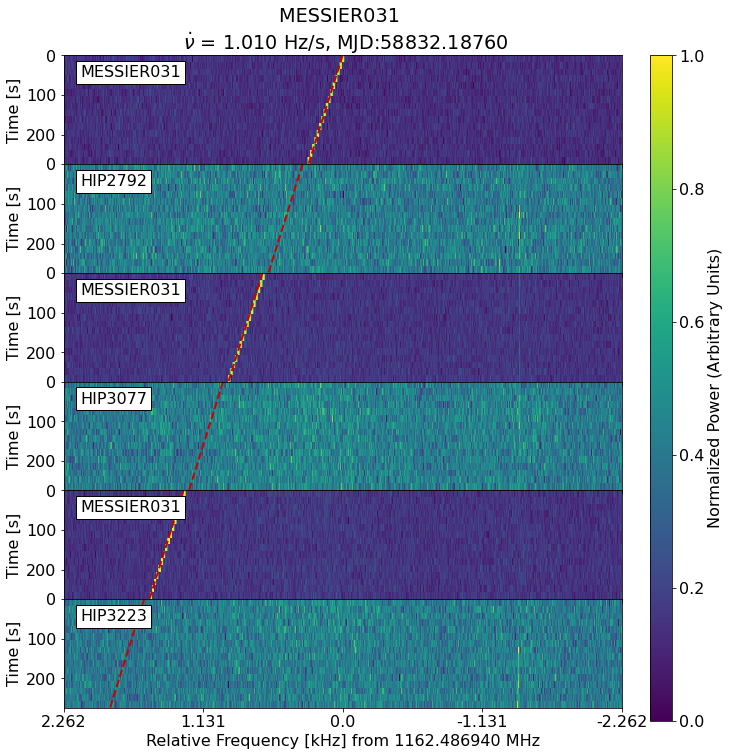

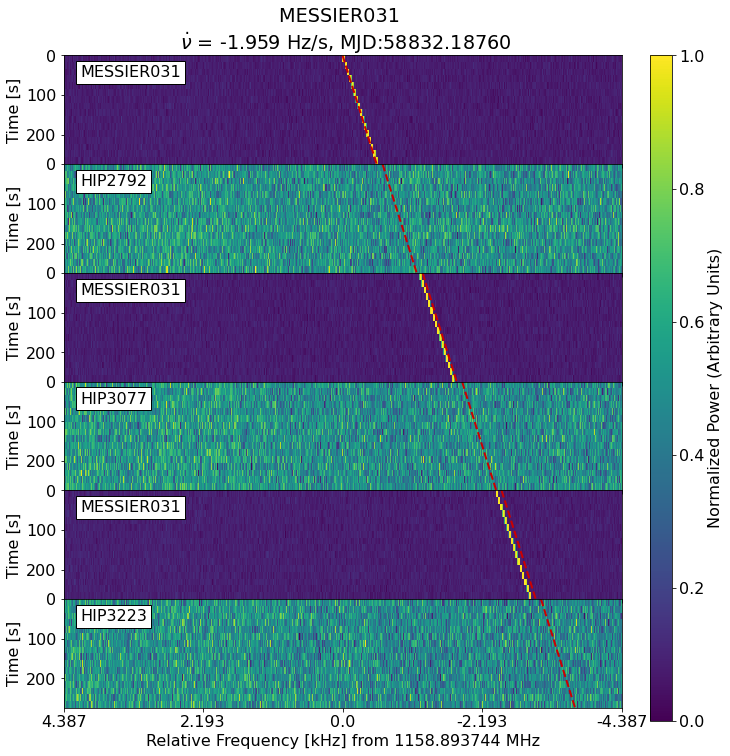

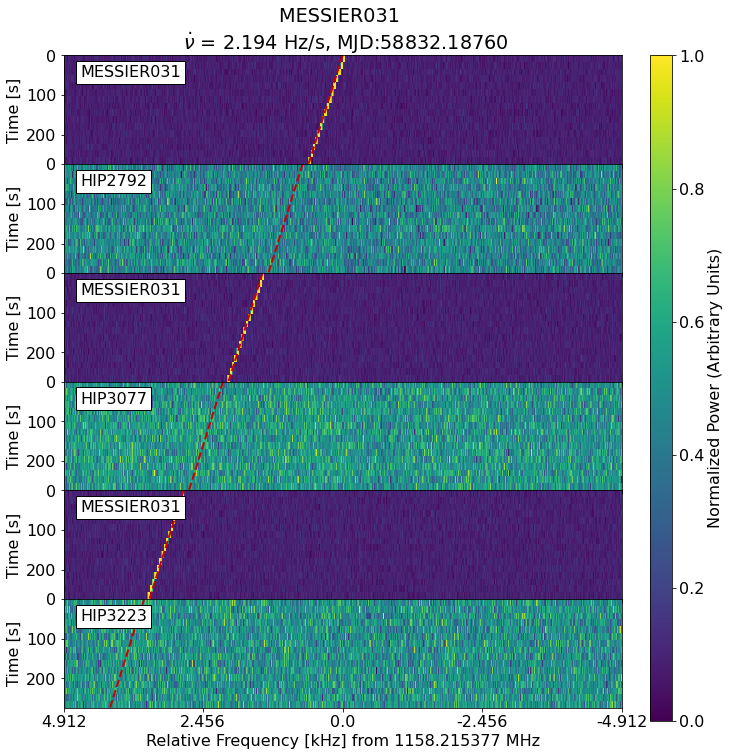

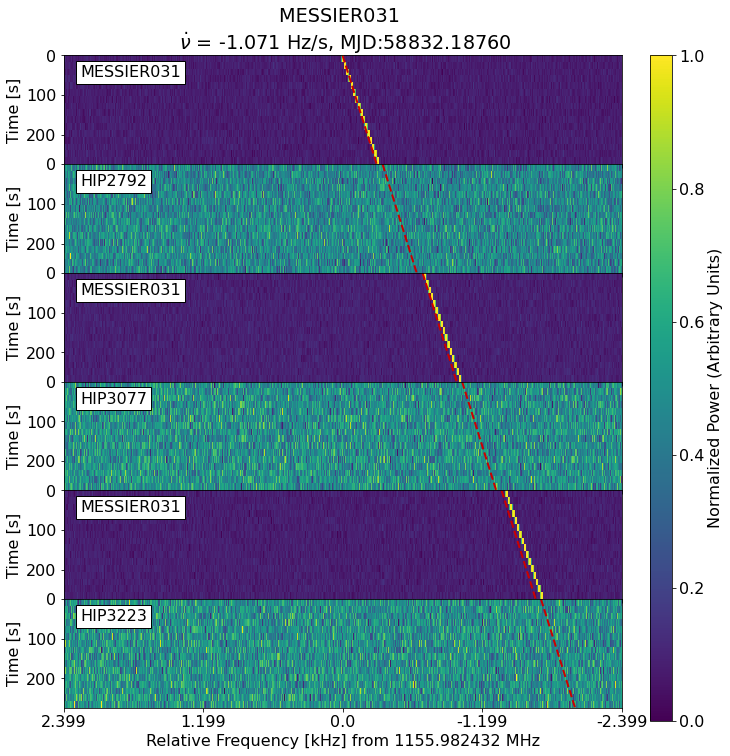

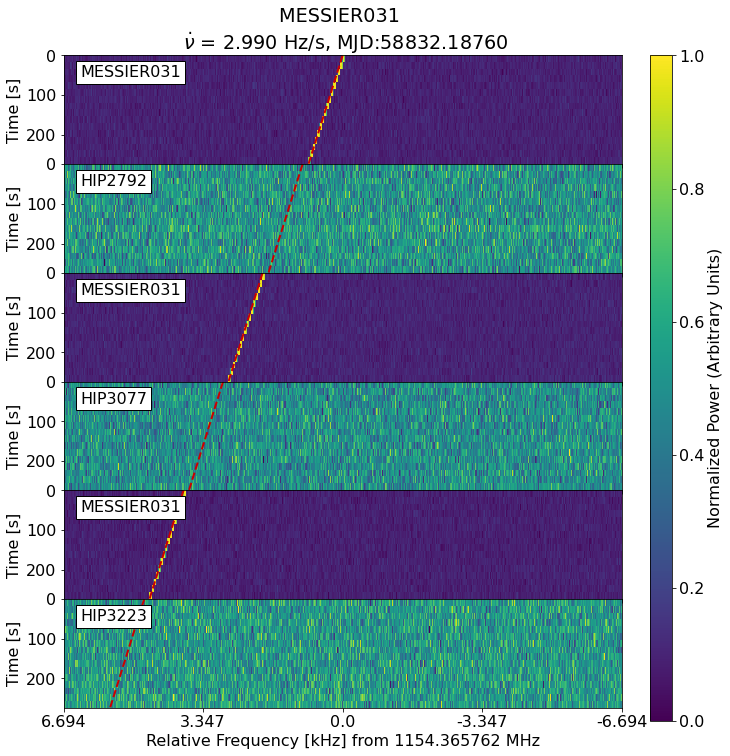

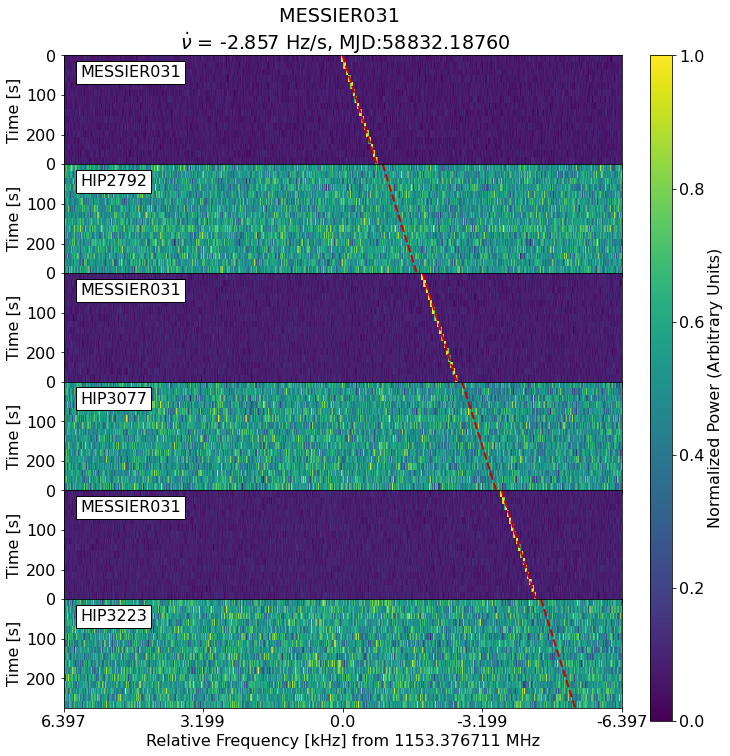

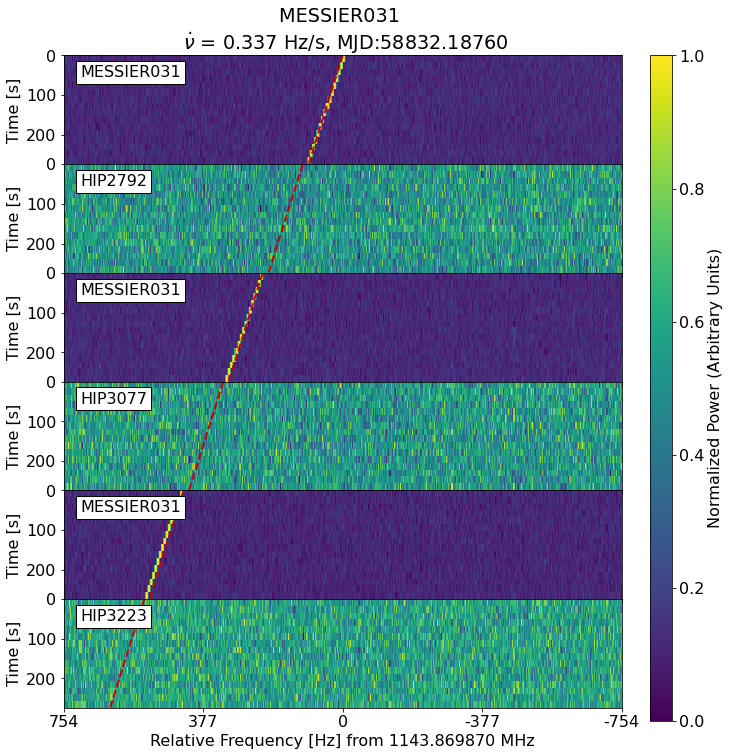

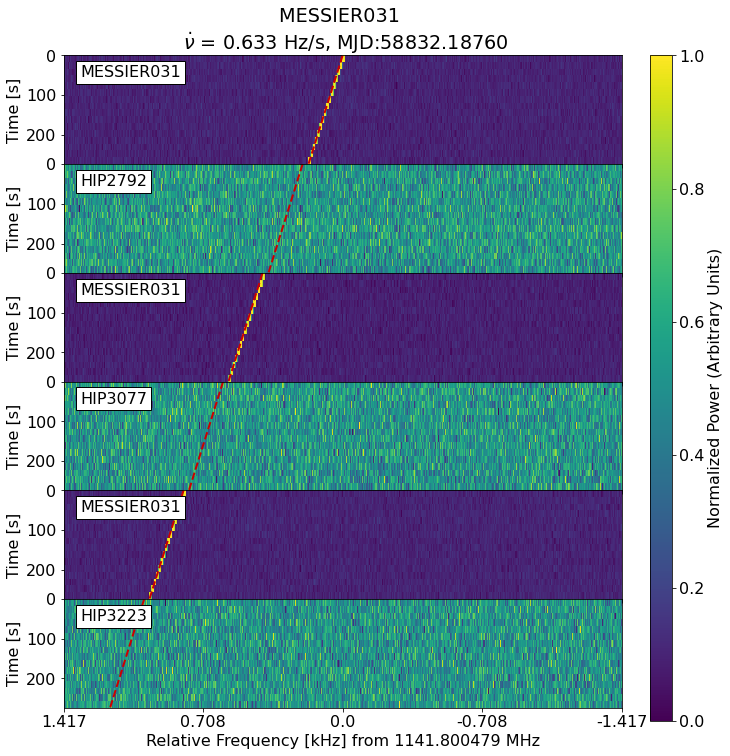

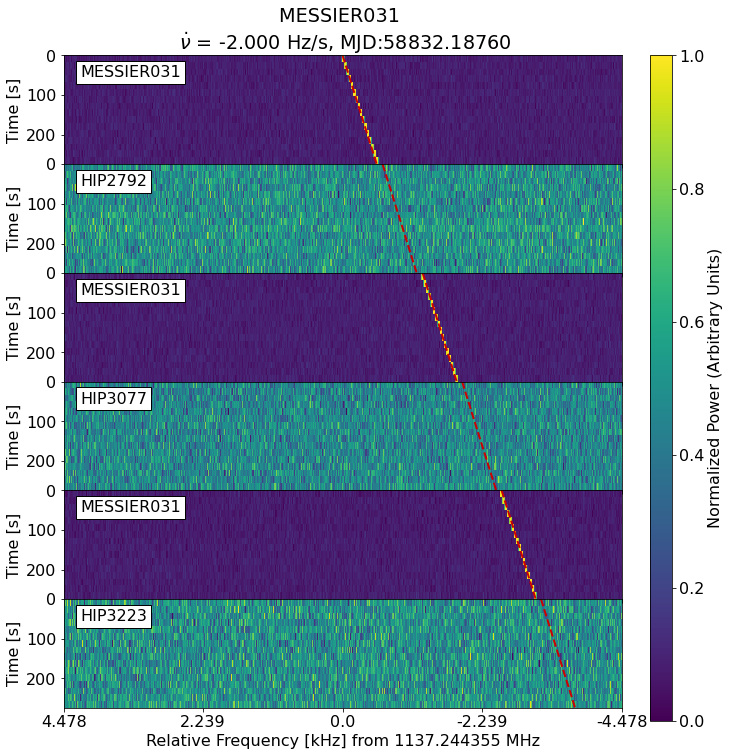

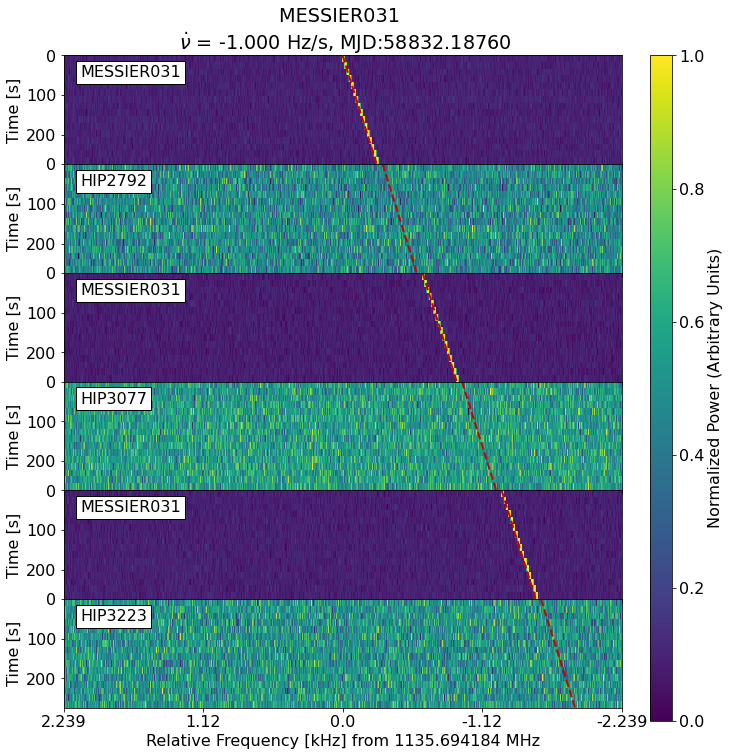

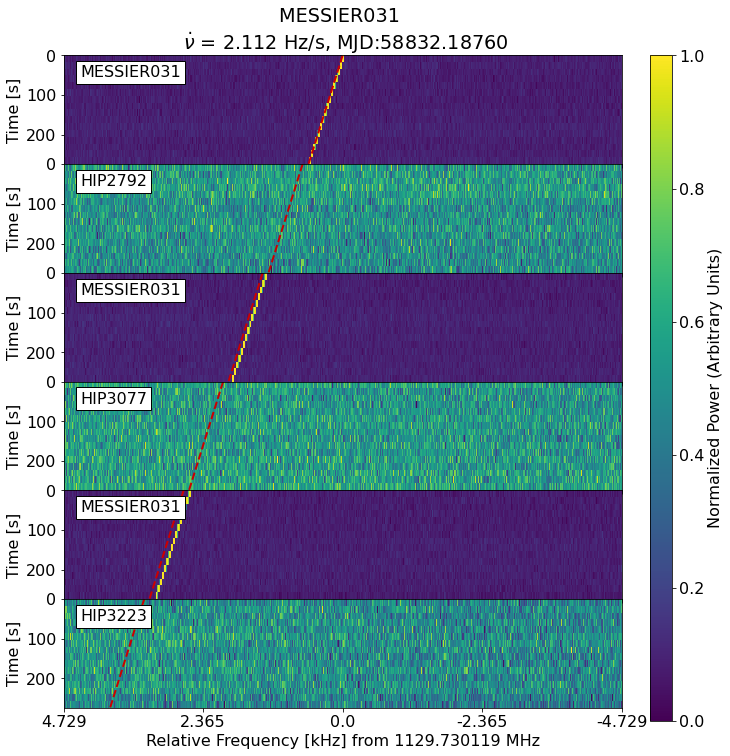

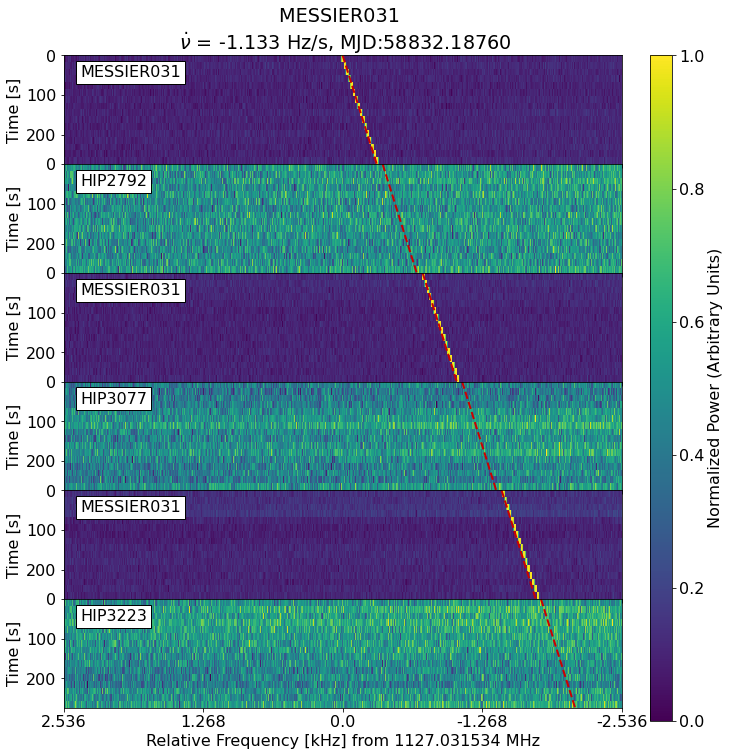

plot_event      INFO     plot_candidate_events: elapsed time = 212.99 seconds


In [70]:
plot_event_pipeline(tcsvf_path, # full path of the CSV file built by find_event_pipeline()
                    h5_list_path, # full path of text file containing the list of .h5 files
                    filter_spec='f{}'.format(3), # filter threshold
                    user_validation=False) # Non-interactive

In [87]:
df_list = glob.glob('/datax/scratch/benjb/C23_L_M31_injections/blc*plus_injections*_trimmed.csv')
for csv in df_list:
    node = os.path.basename(csv)[:5]
    print(node)
    inj_par_path = f'/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_{node}.npy'
    inj_freqs = np.load(inj_par_path, allow_pickle=True)[0]
    inj_drifts = np.load(inj_par_path, allow_pickle=True)[1]
    df = pd.read_csv(csv)
    freqs = df['FreqStart'].values
    print(np.sort(freqs))
    print(len(freqs))
    print(np.sort(inj_freqs))
    print(len(inj_freqs))
    print(inj_drifts[np.argsort(inj_freqs)])
    print('==========')

blc72
[1690.442952 1700.566072 1714.352889 1716.232447 1736.347998 1739.341723
 1745.64328  1749.917847 1754.361001 1773.057454 1795.782808 1801.884878
 1812.358764 1821.025772 1831.329101 1841.542517 1841.551207 1844.622481
 1856.627093 1858.535066 1859.465658 1868.602039]
22
[1690.44075747 1700.56389831 1702.21113491 1714.35068968 1716.23024596
 1736.34578697 1736.69303414 1739.33954138 1745.64109274 1748.71820684
 1749.91569133 1754.35879175 1773.05525891 1795.78060892 1801.88268947
 1812.3565771  1821.02358139 1831.32687437 1841.54031708 1841.54899853
 1844.62029425 1856.62490433 1858.53288064 1859.46345631 1868.59985562]
25
[ 0.68072698 -1.60925152  2.20875813  2.45317632  0.86042917  1.78513622
  0.1466997  -0.82428797 -2.60253756  1.49062259 -2.15267979  1.28933384
  0.46726062  1.37314657 -0.67412423 -2.70072194  2.36612996  2.99920582
  1.21816085  1.36017638 -0.96156382 -1.17359523 -0.51999342  2.00853917
 -1.03040285]
blc73
[1502.403004 1504.852115 1512.169117 1513.657128 15

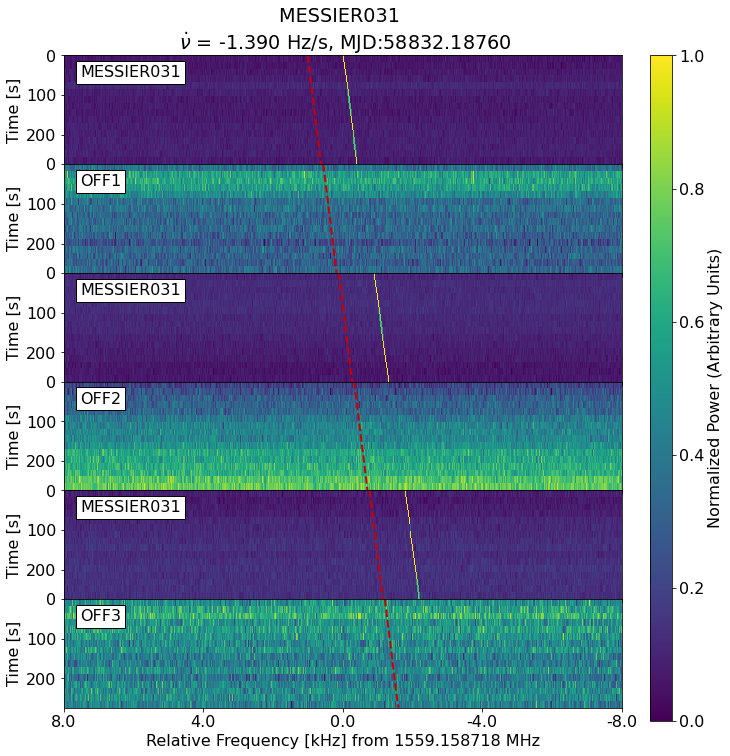

In [3]:
from turbo_seti.find_event import plot_event

#h5_list_path = '/datax/scratch/benjb/C23_L_dats_after_8_HDB_epochs/C23_L_lsts_offs_uncut/395308_HIZSS003_blc04_h5_files.lst'
#csvf_path = '/datax/scratch/benjb/C23_L_dats_after_8_HDB_epochs/C23_L_csvs_offs_uncut/395308_HIZSS003_blc04_f3_trimmed.csv'
h5_list= ['/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
          '/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
          '/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
          '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']
centerfreq = 1559.1587179
source_list = ['MESSIER031',
               'OFF1',
               'MESSIER031',
               'OFF2',
               'MESSIER031',
               'OFF3']

plot_event.make_waterfall_plots(fil_file_list = h5_list, 
                                        on_source_name='MESSIER031',
                                        f_start=centerfreq-0.008,
                                        f_stop=centerfreq+0.008,
                                        drift_rate=-1.39,
                                        f_mid=centerfreq,
                                        filter_level=3,
                                        source_name_list=source_list,
                                        offset=0.001,
                                        plot_dir='/datax/scratch/benjb/C23_L_M31_injections/unfound_injections/zoomed_out/') 